Розробка моделі, здатної ідентифікувати та класифікувати різні рівні токсичності в коментарях, використовуючи можливості BERT (Bidirectional Encoder Representations from Transformers) для аналізу тексту.

В цьому модулі ми виконаємо:
* завантаження попередньо підготовленого датасету
* за необхідності додаткове перетворення формату даних для передачі у модель
* виділення із датасету невиличкої тестової вибірки для тестової побудови та навчання моделі з метою економії обчислювальних даних
* побудову передначеної моделі на основі моделі BERT та підбір її гіперпараметрів.
* feature extraction
* fine tuning
* перевірка чи корректно модель виконує прогнози
* виконання навчання моделі із вибраною архітектурою на повній тестовій вибірці
* фінальні валідаційні тести

Даний модуль виконано на kaggle.com. Для відтворення у іншому оточенні може вимагатись адаптація коду. 

**Частина 1.**

Завантаження, виділення міні-вибірки для тестової побудови моделі, підготовка даних до передачі у модель

In [17]:
import pandas as pd

# Шлях до файлу
file_path = '/kaggle/input/train-data/train_data.csv'

# Завантаження даних
data = pd.read_csv(file_path)

# Перевірка перших кількох рядків
print(data.head())


                 id                               cleaned_comment_text  \
0  0000997932d777bf  Explanation Why the edits made under my userna...   
1  000103f0d9cfb60f  Daww He matches this background colour Im seem...   
2  000113f07ec002fd  Hey man Im really not trying to edit war Its j...   
3  0001b41b1c6bb37e  More I cant make any real suggestions on impro...   
4  0001d958c54c6e35  You sir are my hero Any chance you remember wh...   

                                           input_ids  \
0  [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...   
1  [101, 4830, 2860, 2860, 2002, 3503, 2023, 4281...   
2  [101, 4931, 2158, 10047, 2428, 2025, 2667, 200...   
3  [101, 2062, 1045, 2064, 2102, 2191, 2151, 2613...   
4  [101, 2017, 2909, 2024, 2026, 5394, 2151, 3382...   

                                     attention_masks  toxic  severe_toxic  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0             0   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0     

In [18]:
# виводимо загальну інформацію про вибірку
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    159571 non-null  object
 1   cleaned_comment_text  159571 non-null  object
 2   input_ids             159571 non-null  object
 3   attention_masks       159571 non-null  object
 4   toxic                 159571 non-null  int64 
 5   severe_toxic          159571 non-null  int64 
 6   obscene               159571 non-null  int64 
 7   threat                159571 non-null  int64 
 8   insult                159571 non-null  int64 
 9   identity_hate         159571 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 12.2+ MB


In [19]:
# перевіряємо унікальні значення для кожного класу

# Підрахунок кількості позитивних прикладів для кожного класу
class_distribution = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
print("Кількість позитивних прикладів для кожного класу:\n", class_distribution)

# Загальна кількість прикладів
total_samples = len(data)

# Відсоткове співвідношення по кожному класу
class_percentage = (class_distribution / total_samples) * 100
print("\nВідсоткове співвідношення класів:\n", class_percentage)

# Підрахунок нетоксичних прикладів
non_toxic_count = (data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0).sum()
non_toxic_percentage = (non_toxic_count / total_samples) * 100

# Виведення нетоксичних прикладів
print(f"\nКількість нетоксичних прикладів: {non_toxic_count}")
print(f"Відсоток нетоксичних прикладів: {non_toxic_percentage:.2f}%")


Кількість позитивних прикладів для кожного класу:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Відсоткове співвідношення класів:
 toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
dtype: float64

Кількість нетоксичних прикладів: 143346
Відсоток нетоксичних прикладів: 89.83%


In [65]:
# Створюємо копію даних для міні-вибірки
data_copy = data.copy()

# Створення колонки label_combination
data_copy['label_combination'] = data_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(
    lambda row: '-'.join(row.astype(str)), axis=1
)

# Видалення рідкісних комбінацій міток у копії
label_counts = data_copy['label_combination'].value_counts()
data_copy = data_copy[data_copy['label_combination'].isin(label_counts[label_counts > 1].index)].copy()

# Видалення тимчасової колонки
data_copy.drop(columns=['label_combination'], inplace=True)

# Виділення міні-вибірки (10% даних)
from sklearn.model_selection import train_test_split

data_sample, _ = train_test_split(
    data_copy,
    test_size=0.9,  # 10% в міні-вибірку
    stratify=data_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']],
    random_state=42
)

print(f"Розмір міні-вибірки: {len(data_sample)}")


Розмір міні-вибірки: 15956


In [66]:
# Розмір вибірки все же завеликий для тестових цілей, сменшуємо ще
# Зменшуємо розмір вибірки до 10% без втрати рідкісних класів
smaller_sample_size = int(len(data_sample) * 0.1)

# Вибірка випадкових рядків без порушення пропорцій
data_sample = data_sample.sample(n=smaller_sample_size, random_state=42)

print(f"Кількість прикладів у новій міні-вибірці: {len(data_sample)}")

# Перевіряємо, чи збережені рідкісні класи
class_distribution = data_sample[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
print("Розподіл класів у зменшеній вибірці:\n", class_distribution)

# Підрахунок нетоксичних прикладів
non_toxic_count = (data_sample[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0).sum()

# Виведення нетоксичних прикладів
print(f"\nКількість нетоксичних прикладів: {non_toxic_count}")



Кількість прикладів у новій міні-вибірці: 1595
Розподіл класів у зменшеній вибірці:
 toxic            153
severe_toxic      21
obscene           96
threat             8
insult            80
identity_hate     16
dtype: int64

Кількість нетоксичних прикладів: 1437


In [22]:
import tensorflow as tf

# Перетворення input_ids та attention_masks у списки для міні-вибірки
mini_input_ids = tf.convert_to_tensor(data_sample['input_ids'].apply(eval).tolist())
mini_attention_masks = tf.convert_to_tensor(data_sample['attention_masks'].apply(eval).tolist())

# Перетворення labels у тензор для міні-вибірки
mini_labels = tf.convert_to_tensor(data_sample[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values)

# Перевірка формату міні-вибірки
print(f"mini_input_ids shape: {mini_input_ids.shape}")
print(f"mini_attention_masks shape: {mini_attention_masks.shape}")
print(f"mini_labels shape: {mini_labels.shape}")


mini_input_ids shape: (1595, 128)
mini_attention_masks shape: (1595, 128)
mini_labels shape: (1595, 6)


In [23]:
# Створюємо tf.data.Dataset для міні-вибірки
mini_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': mini_input_ids,
    'attention_mask': mini_attention_masks
}, mini_labels))

# Перевірка кількості прикладів у міні-вибірці
print(f"Кількість прикладів у mini_dataset: {len(mini_dataset)}")

Кількість прикладів у mini_dataset: 1595


In [24]:
# Перевірка структури mini_dataset
for X, Y in mini_dataset.take(1):  # Перевіряємо структуру
    print(f"X (input_ids): {X['input_ids'].shape}")
    print(f"X (attention_mask): {X['attention_mask'].shape}")
    print(f"Y (labels): {Y.shape}")

X (input_ids): (128,)
X (attention_mask): (128,)
Y (labels): (6,)


In [25]:
'''
розбиття вибірки на тренувальну і валідаційну.
Оскільки на цьому етапі ми виконуємо тестову побудову моделі і її точність нам не важлива, 
розділимо вибірку "грубо", ігноруючи диспропорції класів. При роботі із повною вибіркою у
наступних частинах коду цей підхід не припустимий та має бути змінений.
'''
# Розподіл mini_dataset на тренувальну та валідаційну вибірки
validation_split = 0.2  # 20% для валідації
total_size = len(mini_dataset)
val_size = int(total_size * validation_split)

# Використовуємо take() і skip() для поділу
mini_val_dataset = mini_dataset.take(val_size)
mini_train_dataset = mini_dataset.skip(val_size)

# Перевірка розмірів
print(f"Тренувальна вибірка: {len(mini_train_dataset)} прикладів")
print(f"Валідаційна вибірка: {len(mini_val_dataset)} прикладів")


Тренувальна вибірка: 1276 прикладів
Валідаційна вибірка: 319 прикладів


In [26]:
# Мінімальний тест, щоб переконатись, що модель приймає оброблені дані
from transformers import TFBertModel

# Завантажуємо предобучену модель BERT
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Передаємо батч з розміром 1 у модель
for batch in mini_train_dataset.take(1):  # Беремо перший батч
    mini_inputs, mini_labels = batch
    mini_input_ids = tf.expand_dims(mini_inputs['input_ids'], axis=0)  # Додаємо розмір батчу
    mini_attention_mask = tf.expand_dims(mini_inputs['attention_mask'], axis=0)  # Додаємо розмір батчу

    # Передаємо дані у модель
    outputs = bert_model(input_ids=mini_input_ids, attention_mask=mini_attention_mask)
    print("Модель успішно прийняла дані!")
    print(f"Вихідний shape: {outputs.last_hidden_state.shape}")
    break

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Модель успішно прийняла дані!
Вихідний shape: (1, 128, 768)


Модель успішно прийняла данні, що свідчить про те, що підготовка даних для подальної роботи виконана вірно

**Частина 2**

Побудова і навчання тестової міні-моделі

In [27]:
# Створення та тестування кастомного шару для роботи із моделлю БЕРТ

from transformers import TFBertModel
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

# Кастомний шар для інтеграції з BERT
class BertLayer(Layer):
    def __init__(self, pretrained_model_name="bert-base-uncased", trainable=False, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        # Завантажуємо попередньо навчений BERT
        self.bert = TFBertModel.from_pretrained(pretrained_model_name)
        self.bert.trainable = trainable  # Заморожуємо або розморожуємо шари залежно від параметра trainable

    def call(self, inputs):
        # Вхідні дані: input_ids та attention_mask
        input_ids, attention_mask = inputs
        # Передаємо дані через BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # Повертаємо тільки last_hidden_state

# Вхідні тензори
mini_input_ids = Input(shape=(128,), dtype=tf.int32, name="mini_input_ids")
mini_attention_mask = Input(shape=(128,), dtype=tf.int32, name="mini_attention_mask")

# Використовуємо кастомний шар BERT
test_bert_outputs = BertLayer(trainable=False)([mini_input_ids, mini_attention_mask])

# Створюємо базу моделі
test_model = Model(inputs=[mini_input_ids, mini_attention_mask], outputs=test_bert_outputs)

# Перевіряємо архітектуру моделі
test_model.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mini_input_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mini_attention_mask       │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_2 (BertLayer)  │ (None, 128, 768)       │              0 │ mini_input_ids[0][0],  │
│                           │                        │                │ mini_attention_mask[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
'''
підготовка вагів для функції врат щоб врахувати незбалансованість вибірки
'''
# Підрахунок ваг для кожного класу
class_counts = {
    0: 15294,  # toxic
    1: 1595,   # severe_toxic
    2: 8449,   # obscene
    3: 478,    # threat
    4: 7877,   # insult
    5: 1405    # identity_hate
}

# Загальна кількість прикладів у вибірці
total_samples = 159571

# Вага для кожного класу буде пропорційною оберненому співвідношенню його частоти
class_weights = {}
for label, count in class_counts.items():
    # Вага класу розраховується як обернене відношення загальної кількості прикладів
    class_weights[label] = total_samples / count

# Нормалізація ваг класів, щоб їх сума була рівна 1
class_weights = {k: v / sum(class_weights.values()) for k, v in class_weights.items()}

# Виведення ваг класів
print(f"Вага класів: {class_weights}")


Вага класів: {0: 0.017475888539927716, 1: 0.16757130992454825, 2: 0.03163406785769375, 3: 0.5591553124051349, 4: 0.03393122246155319, 5: 0.190232198811142}


In [29]:
'''
у якості метрики обрано Ф-1 у зв'язку із незбалансованістю класів. 
Підготуємо функцію для неї
'''

import tensorflow as tf
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    # Преобразуем в бинарный формат для каждого класса
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(K.greater_equal(y_pred, 0.5), 'int32')

    # Вычисляем точность (precision) и полноту (recall)
    true_positive = K.sum(K.cast(y_true * y_pred, 'float32'))
    false_positive = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))
    false_negative = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))

    precision = true_positive / (true_positive + false_positive + K.epsilon())
    recall = true_positive / (true_positive + false_negative + K.epsilon())

    # F1-score = 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1


In [47]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_f1_loss(y_true, y_pred, class_weights):
    """
    Кастомна функція втрат для оптимізації макро F1-міри з урахуванням ваг класів.
    
    Args:
        y_true: tf.Tensor, істинні мітки (розмірність [batch_size, num_classes]).
        y_pred: tf.Tensor, передбачення моделі (розмірність [batch_size, num_classes]).
        class_weights: dict, ваги класів (ключі - індекси класів, значення - ваги).

    Returns:
        tf.Tensor, значення функції втрат.
    """
    # Застосовуємо сигмоїду до передбачень, якщо вони ще не пройшли через активацію
    y_pred = K.sigmoid(y_pred)

    # Перетворення ваг класів у тензор
    class_weight_tensor = tf.constant([class_weights[i] for i in range(len(class_weights))], dtype=tf.float32)

    # Обчислення TP, FP, FN
    true_positives = K.sum(y_true * y_pred, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)
    actual_positives = K.sum(y_true, axis=0)

    # Обчислення Precision та Recall для кожного класу
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    # Обчислення F1 для кожного класу
    f1_per_class = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Застосування ваг класів
    weighted_f1 = f1_per_class * class_weight_tensor

    # Середнє значення макро F1
    macro_f1 = K.mean(weighted_f1)

    # Повернення від'ємного значення F1 як функції втрат (для мінімізації)
    return 1 - macro_f1


In [48]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

# Вхідні тензори, що відповідають підготовленим даним
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Використання кастомного шару BERT
bert_outputs = BertLayer(trainable=False)([input_ids, attention_mask])

# Додавання пулингу та денс-шарів
pooled_output = GlobalAveragePooling1D()(bert_outputs)
dense_output = Dense(256, activation="swish", name="dense_layer_1")(pooled_output)
dropout_output = Dropout(0.3, name="dropout_layer_1")(dense_output)
final_output = Dense(6, activation="sigmoid", name="output_layer")(dropout_output)

# Створення моделі
mini_model = Model(inputs=[input_ids, attention_mask], outputs=final_output)

# Компіляція моделі
mini_model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: weighted_f1_loss(y_true, y_pred, class_weights),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), f1_metric]
)

# Перевірка архітектури моделі
mini_model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_9 (BertLayer)  │ (None, 128, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ bert_layer_9[0][0]     │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer_1 (Dense)     │ (None, 256)            │        196,864 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_layer_1 (Dropout) │ (None, 256)            │              0 │ dense_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 6)              │          1,542 │ dropout_layer_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 198,406 (775.02 KB)

 Trainable params: 198,406 (775.02 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Додавання розбиття на батчі
mini_train_dataset_batched = mini_train_dataset.batch(32)
mini_val_dataset_batched = mini_val_dataset.batch(32)

# Додавання ранньої зупинки
early_stopping = EarlyStopping(
    monitor="val_f1_metric",  # Моніторимо F1-score на валідаційній вибірці
    mode="max",  # Ми хочемо максимізувати F1-score
    patience=3,  # Чекаємо 3 епохи без покращення
    restore_best_weights=True  # Повертаємо ваги найкращої моделі
)

# Навчання моделі з додаванням ранньої зупинки
mini_history = mini_model.fit(
    mini_train_dataset_batched,  # Тренувальна вибірка
    validation_data=mini_val_dataset_batched,  # Валідаційна вибірка
    epochs=10,  
    callbacks=[early_stopping]  # Додаємо ранню зупинку
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 776ms/step - accuracy: 0.3621 - f1_metric: 0.0674 - loss: 0.9973 - precision: 0.0356 - recall: 0.8510 - val_accuracy: 0.6270 - val_f1_metric: 0.0602 - val_loss: 0.9972 - val_precision: 0.0321 - val_recall: 1.0000
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.3671 - f1_metric: 0.0665 - loss: 0.9973 - precision: 0.0349 - recall: 0.9362 - val_accuracy: 0.8464 - val_f1_metric: 0.0598 - val_loss: 0.9972 - val_precision: 0.0318 - val_recall: 1.0000
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - accuracy: 0.5059 - f1_metric: 0.0655 - loss: 0.9973 - precision: 0.0341 - recall: 0.9585 - val_accuracy: 0.8777 - val_f1_metric: 0.0601 - val_loss: 0.9972 - val_precision: 0.0320 - val_recall: 1.0000
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.6398 - f1_metric: 0.0679 - loss: 0.9973 - precision: 0.0355 - recall: 0.9918 - val_accuracy: 0.9248 - val_f1_metric: 0.0605 - val_loss: 0.9972 - val_precision: 0.0323 -

У вибірці переважають приклади негативних класів, через що модель схиляється до прогнозування лише цих класів. Це спричиняє недостатнысть позитивних прогнозів, що, у свою чергу, призводить до низьких значень precision та f1_metric.

Проте оскільки тестова модель працює із дуже малою вибіркою, при передачі на навчання повної вибірки, ситуація може дуже покращитись. 

Оскільки мета данного етапу робіт підготувати та протестувати лише, чи підготовлений код робочий, фактичні результати тимчасово проігноруємо та перейдемо до наступних етапів - донавчання моделі із розмороженими верхніми шарами.

In [50]:
# Розморожування верхніх шарів моделі BERT
for layer in mini_model.layers:
    if isinstance(layer, BertLayer):  # Перевіряємо, чи є шаром BERT
        layer.bert.trainable = True  # Розморожуємо шари для навчання

# Повторна компіляція моделі з меншою швидкістю навчання
mini_model.compile(
    optimizer=Nadam(learning_rate=1e-5),  # Зменшена швидкість навчання
    loss=lambda y_true, y_pred: weighted_f1_loss(y_true, y_pred, class_weights),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), f1_metric]
)

# Файн-тюнінг моделі (навчання з розмороженими шарами)
mini_fine_tune_history = mini_model.fit(
    mini_train_dataset_batched,  # Тренувальний датасет
    validation_data=mini_val_dataset_batched,  # Валідаційний датасет
    epochs=3  # Кількість епох
)


Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 753ms/step - accuracy: 0.8864 - f1_metric: 0.0787 - loss: 0.9972 - precision: 0.0413 - recall: 0.9865 - val_accuracy: 0.9624 - val_f1_metric: 0.0681 - val_loss: 0.9972 - val_precision: 0.0365 - val_recall: 0.9667
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.8818 - f1_metric: 0.0792 - loss: 0.9972 - precision: 0.0417 - recall: 0.9871 - val_accuracy: 0.9624 - val_f1_metric: 0.0682 - val_loss: 0.9972 - val_precision: 0.0365 - val_recall: 0.9667
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.8759 - f1_metric: 0.0786 - loss: 0.9972 - precision: 0.0414 - recall: 0.9823 - val_accuracy: 0.9624 - val_f1_metric: 0.0685 - val_loss: 0.9972 - val_precision: 0.0367 - val_recall: 0.9667


Результати метрики F-1 після фінтюнінгу все ще дуже малі, при роботі з повною вибіркою очікується що модель матиме більше прикладів токсичних коментарів різних типів і навчиться краще їх розрізняти. 

Мета поточного етапу підготувати робочу версію шаблону коду для подальшого навчання моделі. Код відпрацював без помилок і його можна приймати як базу для подальшої роботи. 

**Частина 3**

Підготовка повної вибірки для передачі у модель

In [51]:
from sklearn.model_selection import train_test_split

# Створюємо копію даних для розділення
data_copy = data.copy()

# Створення колонки label_combination
data_copy['label_combination'] = data_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(
    lambda row: '-'.join(row.astype(str)), axis=1
)

# Видалення рідкісних комбінацій міток у копії
label_counts = data_copy['label_combination'].value_counts()
data_copy = data_copy[data_copy['label_combination'].isin(label_counts[label_counts > 1].index)].copy()

# Видалення тимчасової колонки
data_copy.drop(columns=['label_combination'], inplace=True)

# Розділення на тренувальну і валідаційну вибірки
train_data, val_data = train_test_split(
    data_copy,
    test_size=0.2,  # 20% для валідації
    stratify=data_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']],
    random_state=42
)

# Перевірка розмірів
print(f"Тренувальна вибірка: {len(train_data)} прикладів")
print(f"Валідаційна вибірка: {len(val_data)} прикладів")


Тренувальна вибірка: 127655 прикладів
Валідаційна вибірка: 31914 прикладів


In [52]:
# перевіряємо унікальні значення для кожного класу для тренувальної вибірки

# Підрахунок кількості позитивних прикладів для кожного класу
class_distribution = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
print("Кількість позитивних прикладів для кожного класу:\n", class_distribution)

# Загальна кількість прикладів
total_samples = len(train_data)

# Відсоткове співвідношення по кожному класу
class_percentage = (class_distribution / total_samples) * 100
print("\nВідсоткове співвідношення класів:\n", class_percentage)

# Підрахунок нетоксичних прикладів
non_toxic_count = (train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0).sum()
non_toxic_percentage = (non_toxic_count / total_samples) * 100

# Виведення нетоксичних прикладів
print(f"\nКількість нетоксичних прикладів: {non_toxic_count}")
print(f"Відсоток нетоксичних прикладів: {non_toxic_percentage:.2f}%")

Кількість позитивних прикладів для кожного класу:
 toxic            12233
severe_toxic      1274
obscene           6759
threat             382
insult            6300
identity_hate     1122
dtype: int64

Відсоткове співвідношення класів:
 toxic            9.582860
severe_toxic     0.998002
obscene          5.294740
threat           0.299244
insult           4.935177
identity_hate    0.878931
dtype: float64

Кількість нетоксичних прикладів: 114677
Відсоток нетоксичних прикладів: 89.83%


In [53]:
# перевіряємо унікальні значення для кожного класу для валідаційної вибірки

# Підрахунок кількості позитивних прикладів для кожного класу
class_distribution = val_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
print("Кількість позитивних прикладів для кожного класу:\n", class_distribution)

# Загальна кількість прикладів
total_samples = len(val_data)

# Відсоткове співвідношення по кожному класу
class_percentage = (class_distribution / total_samples) * 100
print("\nВідсоткове співвідношення класів:\n", class_percentage)

# Підрахунок нетоксичних прикладів
non_toxic_count = (val_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0).sum()
non_toxic_percentage = (non_toxic_count / total_samples) * 100

# Виведення нетоксичних прикладів
print(f"\nКількість нетоксичних прикладів: {non_toxic_count}")
print(f"Відсоток нетоксичних прикладів: {non_toxic_percentage:.2f}%")

Кількість позитивних прикладів для кожного класу:
 toxic            3059
severe_toxic      319
obscene          1690
threat             94
insult           1576
identity_hate     282
dtype: int64

Відсоткове співвідношення класів:
 toxic            9.585135
severe_toxic     0.999561
obscene          5.295482
threat           0.294542
insult           4.938272
identity_hate    0.883625
dtype: float64

Кількість нетоксичних прикладів: 28669
Відсоток нетоксичних прикладів: 89.83%


Вибірка розподілена рівномірно з врахуванням пропорцій класів.

In [54]:
# Перетворення тренувальної вибірки

import tensorflow as tf

# Перетворення input_ids та attention_masks у списки
input_ids = tf.convert_to_tensor(train_data['input_ids'].apply(eval).tolist())
attention_masks = tf.convert_to_tensor(train_data['attention_masks'].apply(eval).tolist())

# Перетворення labels у тензор
labels = tf.convert_to_tensor(train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values)

# Перевірка формату
print(f"input_ids shape: {input_ids.shape}")
print(f"attention_masks shape: {attention_masks.shape}")
print(f"labels shape: {labels.shape}")

# Створюємо tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': input_ids,
    'attention_mask': attention_masks
}, labels))

# Перевірка кількості прикладів
print(f"Кількість прикладів у dataset: {len(train_dataset)}")

# Перевірка структури train_dataset
for X, Y in train_dataset.take(1):  # Перевіряємо структуру
    print(f"X (input_ids): {X['input_ids'].shape}")
    print(f"X (attention_mask): {X['attention_mask'].shape}")
    print(f"Y (labels): {Y.shape}")

input_ids shape: (127655, 128)
attention_masks shape: (127655, 128)
labels shape: (127655, 6)
Кількість прикладів у dataset: 127655
X (input_ids): (128,)
X (attention_mask): (128,)
Y (labels): (6,)


In [55]:
# Перетворення валідаційної вибірки

# Перетворення input_ids та attention_masks у списки для валідаційної вибірки
val_input_ids = tf.convert_to_tensor(val_data['input_ids'].apply(eval).tolist())
val_attention_masks = tf.convert_to_tensor(val_data['attention_masks'].apply(eval).tolist())

# Перетворення labels у тензор для валідаційної вибірки
val_labels = tf.convert_to_tensor(val_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values)

# Перевірка формату
print(f"val_input_ids shape: {val_input_ids.shape}")
print(f"val_attention_masks shape: {val_attention_masks.shape}")
print(f"val_labels shape: {val_labels.shape}")

# Створюємо tf.data.Dataset для валідаційної вибірки
val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_input_ids,
    'attention_mask': val_attention_masks
}, val_labels))

# Перевірка кількості прикладів
print(f"Кількість прикладів у val_dataset: {len(val_dataset)}")

# Перевірка структури val_dataset
for X, Y in val_dataset.take(1):  # Перевіряємо структуру
    print(f"X (val_input_ids): {X['input_ids'].shape}")
    print(f"X (val_attention_mask): {X['attention_mask'].shape}")
    print(f"Y (val_labels): {Y.shape}")


val_input_ids shape: (31914, 128)
val_attention_masks shape: (31914, 128)
val_labels shape: (31914, 6)
Кількість прикладів у val_dataset: 31914
X (val_input_ids): (128,)
X (val_attention_mask): (128,)
Y (val_labels): (6,)


In [56]:
# Мінімальний тест, щоб переконатись, що модель приймає оброблені дані
from transformers import TFBertModel

# Завантажуємо предобучену модель BERT
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Передаємо батч з розміром 1 у модель
for batch in train_dataset.take(1):  # Беремо перший батч
    inputs, labels = batch
    input_ids = tf.expand_dims(inputs['input_ids'], axis=0)  # Додаємо розмір батчу
    attention_mask = tf.expand_dims(inputs['attention_mask'], axis=0)  # Додаємо розмір батчу

    # Передаємо дані у модель
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    print("Модель успішно прийняла дані!")
    print(f"Вихідний shape: {outputs.last_hidden_state.shape}")
    break

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Модель успішно прийняла дані!
Вихідний shape: (1, 128, 768)


**Частина 4**

Створення моделі та навчання на повній вибірці даних

In [57]:
# Вхідні тензори
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Використання кастомного шару BERT
bert_outputs = BertLayer(trainable=False)([input_ids, attention_mask])

# Додавання пулингу та денс-шарів
pooled_output = GlobalAveragePooling1D()(bert_outputs)
dense_output = Dense(256, activation="swish", name="dense_layer_1")(pooled_output)
dropout_output = Dropout(0.3, name="dropout_layer_1")(dense_output)
final_output = Dense(6, activation="sigmoid", name="output_layer")(dropout_output)

# Створення моделі
model = Model(inputs=[input_ids, attention_mask], outputs=final_output)

# Компіляція моделі
model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: weighted_f1_loss(y_true, y_pred, class_weights),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), f1_metric]
)

# Перевірка архітектури моделі
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_10 (BertLayer) │ (None, 128, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ bert_layer_10[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer_1 (Dense)     │ (None, 256)            │        196,864 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_layer_1 (Dropout) │ (None, 256)            │              0 │ dense_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 6)              │          1,542 │ dropout_layer_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 198,406 (775.02 KB)

 Trainable params: 198,406 (775.02 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Додавання розбиття на батчі, для повної вибірки розмір батчу збільшено
train_dataset_batched = train_dataset.batch(128)
val_dataset_batched = val_dataset.batch(128)

# Додавання ранньої зупинки
early_stopping_new = EarlyStopping(
    monitor="val_f1_metric",  # Моніторимо F1-score на валідаційній вибірці
    mode="max",  # Ми хочемо максимізувати F1-score
    patience=10,  # Чекаємо 10 епох без покращення
    restore_best_weights=True  # Повертаємо ваги найкращої моделі
)

# Навчання моделі з додаванням ранньої зупинки
history = model.fit(
    train_dataset_batched,  # Тренувальна вибірка
    validation_data=val_dataset_batched,  # Валідаційна вибірка
    epochs=50,  # Збільшено кількість епох
    callbacks=[early_stopping_new]  # Додаємо ранню зупинку
)

Epoch 1/50
998/998 ━━━━━━━━━━━━━━━━━━━━ 1284s 1s/step - accuracy: 0.5651 - f1_metric: 0.0825 - loss: 0.9968 - precision: 0.0433 - recall: 0.8713 - val_accuracy: 0.8528 - val_f1_metric: 0.0970 - val_loss: 0.9968 - val_precision: 0.0521 - val_recall: 0.7269
Epoch 2/50
998/998 ━━━━━━━━━━━━━━━━━━━━ 1251s 1s/step - accuracy: 0.5937 - f1_metric: 0.0931 - loss: 0.9968 - precision: 0.0503 - recall: 0.6711 - val_accuracy: 0.8996 - val_f1_metric: 0.0924 - val_loss: 0.9968 - val_precision: 0.0498 - val_recall: 0.6725
Epoch 3/50
998/998 ━━━━━━━━━━━━━━━━━━━━ 1248s 1s/step - accuracy: 0.6232 - f1_metric: 0.0919 - loss: 0.9968 - precision: 0.0497 - recall: 0.6467 - val_accuracy: 0.5147 - val_f1_metric: 0.0916 - val_loss: 0.9967 - val_precision: 0.0495 - val_recall: 0.6500
Epoch 4/50
998/998 ━━━━━━━━━━━━━━━━━━━━ 1249s 1s/step - accuracy: 0.5727 - f1_metric: 0.0906 - loss: 0.9968 - precision: 0.0490 - recall: 0.6500 - val_accuracy: 0.7074 - val_f1_metric: 0.0898 - val_loss: 0.9967 - val_precision: 0.04

In [59]:
model.save("model.h5")

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Підготовка даних з mini_dataset замість тестових
x_test = []
y_test = []

for x, y in mini_dataset.batch(1):
    x_test.append({
        'input_ids': x['input_ids'][0].numpy(),
        'attention_mask': x['attention_mask'][0].numpy()
    })
    y_test.append(y.numpy()[0])

y_test = np.array(y_test)

# Додання класу нетоксичних коментарів у мітки (всі нулі)
all_zeros_class = np.all(y_test == 0, axis=1)
y_test_expanded = np.hstack((y_test, all_zeros_class.reshape(-1, 1)))

# Перетворення x_test в формат, зрозумілий моделі
input_ids = np.array([sample['input_ids'] for sample in x_test])
attention_masks = np.array([sample['attention_mask'] for sample in x_test])

# Прогнозування
predictions = mini_model.predict({'input_ids': input_ids, 'attention_mask': attention_masks})
predicted_classes = (predictions > 0.5).astype(int)  # Бінарізація прогнозу

# Додання класу нетоксичних коментарів у прогноз
predicted_all_zeros_class = np.all(predicted_classes == 0, axis=1)
predicted_classes_expanded = np.hstack((predicted_classes, predicted_all_zeros_class.reshape(-1, 1)))

# Оцінка моделі
print("\nКласифікаційний звіт:\n")
print(classification_report(y_test_expanded, predicted_classes_expanded, target_names=[
    "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "non_toxic"
]))


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step

Класифікаційний звіт:

               precision    recall  f1-score   support

        toxic       0.10      1.00      0.18       153
 severe_toxic       0.02      0.71      0.03        21
      obscene       0.06      1.00      0.11        96
       threat       0.01      0.88      0.02         8
       insult       0.05      1.00      0.10        80
identity_hate       0.01      1.00      0.02        16
    non_toxic       0.00      0.00      0.00      1437

    micro avg       0.05      0.20      0.08      1811
    macro avg       0.03      0.80      0.07      1811
 weighted avg       0.01      0.20      0.03      1811
  samples avg       0.05      0.10      0.06      1811



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# Розподіл класів в predicted_classes_expanded
predicted_class_distribution = np.sum(predicted_classes_expanded, axis=0)
print("\nРозподіл класів в predicted_classes_expanded:")
for i, count in enumerate(predicted_class_distribution):
    print(f"Клас {i}: {count}")


Розподіл класів в predicted_classes_expanded:
Клас 0: 1595
Клас 1: 923
Клас 2: 1595
Клас 3: 608
Клас 4: 1595
Клас 5: 1591
Клас 6: 0


In [79]:
# Розподіл дійсних класів
class_distribution = np.sum(y_test_expanded, axis=0)
print("Розподіл класів в y_test_expanded:")
for i, count in enumerate(class_distribution):
    print(f"Клас {i}: {count}")


Розподіл класів в y_test_expanded:
Клас 0: 153
Клас 1: 21
Клас 2: 96
Клас 3: 8
Клас 4: 80
Клас 5: 16
Клас 6: 1437


Confusion matrix for 'toxic':
[[   0 1442]
 [   0  153]]


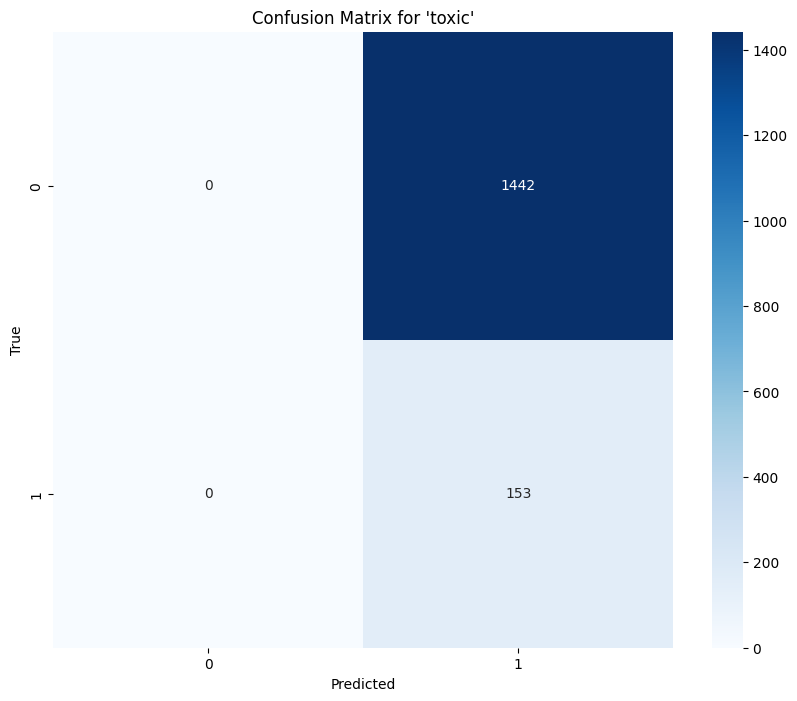

In [80]:
from sklearn.metrics import multilabel_confusion_matrix

# Побудова багатоміткової confusion matrix
conf_matrices = multilabel_confusion_matrix(y_test_expanded, predicted_classes_expanded)

# Приклад виводу для окремої мітки (наприклад, "toxic")
print("Confusion matrix for 'toxic':")
print(conf_matrices[0])

# Візуалізація:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrices[0], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for 'toxic'")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Цей код не виконувався і показаний для прикладу
# Розморожування верхніх шарів моделі BERT
for layer in model.layers:
    if isinstance(layer, BertLayer):  # Перевіряємо, чи є шаром BERT
        layer.bert.trainable = True  # Розморожуємо шари для навчання

# Повторна компіляція моделі з меншою швидкістю навчання
model.compile(
    optimizer=Nadam(learning_rate=1e-5),  # Зменшена швидкість навчання
    loss=lambda y_true, y_pred: weighted_f1_loss(y_true, y_pred, class_weights),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), f1_metric]
)

# Файн-тюнінг моделі (навчання з розмороженими шарами)
'''
Через погані результати попреднього етапу навчання моделі, скорочуємо кількість епох для мінімізації 
обчислень і отримання мінімальної робочої моделі для тестування наступних модулів. Паралельно буде 
продовжена робота зі створення моделі із прийнятними результатами 
'''
fine_tune_history = model.fit(
    train_dataset_batched,  # Тренувальний датасет
    validation_data=val_dataset_batched,  # Валідаційний датасет
    epochs=5
)
